In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
IMAGE_PATH = 'C:\\Users\\USER\\Desktop\\MrShahrullo\\UNET\\dataset1\\original_images\\'
MASK_PATH = 'C:\\Users\\USER\\Desktop\\MrShahrullo\\UNET\\dataset1\\label_images_semantic\\'

In [3]:
MASK_PATH

'C:\\Users\\USER\\Desktop\\MrShahrullo\\UNET\\dataset1\\label_images_semantic\\'

In [4]:
n_classes = 23 

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  400


In [5]:
#split data
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  306
Val Size     :  54
Test Size    :  40


In [6]:
# def get_dataloaders():
    
#     # trn_ds = SegDataset('train')
#     # val_ds = SegDataset('test')
    
#     trn_dl = DataLoader(X_train, batch_size=8, shuffle=True, collate_fn=trn_ds.collate_fn)
#     val_dl = DataLoader(X_val, batch_size=8, shuffle=False, collate_fn=val_ds.collate_fn)
    
#     return trn_dl, val_dl

Image Size (4000, 6000, 3)
Mask Size (4000, 6000)


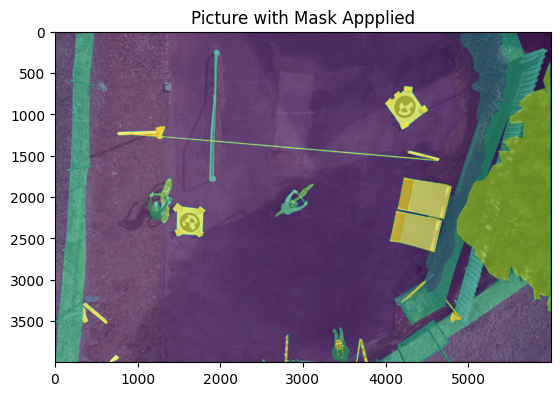

In [7]:
img = Image.open(IMAGE_PATH + df['id'][10] + '.jpg')
mask = Image.open(MASK_PATH + df['id'][10] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

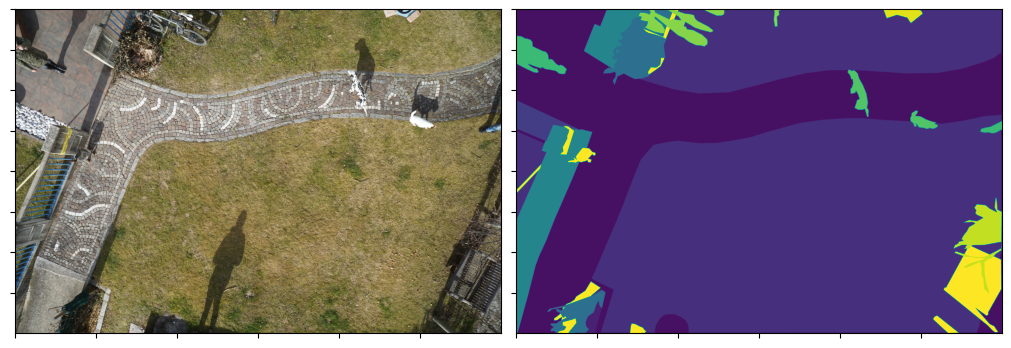

In [8]:
# Show input sample 
 
fig, axs = plt.subplots(1, 2, figsize=(10, 8), constrained_layout=True)
axs[0].set_yticklabels([])
axs[0].set_xticklabels([])
axs[0].imshow( Image.open(IMAGE_PATH+"008.jpg"))

axs[1].set_yticklabels([])
axs[1].set_xticklabels([])
label_image_semantic = Image.open(MASK_PATH+"008.png")
axs[1].imshow(label_image_semantic)


In [9]:
class DroneDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
        
        if self.patches:
            img, mask = self.tiles(img, mask)
            
        return img, mask
    
    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768) 
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768) 
        img_patches = img_patches.permute(1,0,2,3)
        
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches

In [10]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size= 2 

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)               

In [11]:
#model
model = smp.Unet('efficientnet-b0', encoder_weights='imagenet', classes=23, activation=None)

In [12]:
model

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePadding

In [13]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [14]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [15]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [16]:
max_lr = 1e-3
epoch = 100
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 2.578 
Epoch:1/100.. Train Loss: 2.857.. Val Loss: 2.578.. Train mIoU:0.052.. Val mIoU: 0.059.. Train Acc:0.320.. Val Acc:0.337.. Time: 2.86m


  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Decreasing.. 2.578 >> 2.107 
Epoch:2/100.. Train Loss: 2.319.. Val Loss: 2.107.. Train mIoU:0.077.. Val mIoU: 0.080.. Train Acc:0.440.. Val Acc:0.425.. Time: 2.83m


  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Decreasing.. 2.107 >> 1.744 
Epoch:3/100.. Train Loss: 1.908.. Val Loss: 1.744.. Train mIoU:0.106.. Val mIoU: 0.120.. Train Acc:0.538.. Val Acc:0.568.. Time: 2.82m


  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Decreasing.. 1.744 >> 1.540 
saving model...
Epoch:4/100.. Train Loss: 1.662.. Val Loss: 1.540.. Train mIoU:0.122.. Val mIoU: 0.129.. Train Acc:0.584.. Val Acc:0.616.. Time: 2.81m


  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Decreasing.. 1.540 >> 1.346 
Epoch:5/100.. Train Loss: 1.470.. Val Loss: 1.346.. Train mIoU:0.138.. Val mIoU: 0.163.. Train Acc:0.615.. Val Acc:0.660.. Time: 2.83m


  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Decreasing.. 1.346 >> 1.210 
Epoch:6/100.. Train Loss: 1.323.. Val Loss: 1.210.. Train mIoU:0.160.. Val mIoU: 0.174.. Train Acc:0.652.. Val Acc:0.702.. Time: 10.49m


  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Decreasing.. 1.210 >> 1.147 
Epoch:7/100.. Train Loss: 1.225.. Val Loss: 1.147.. Train mIoU:0.173.. Val mIoU: 0.187.. Train Acc:0.670.. Val Acc:0.706.. Time: 2.88m


  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Decreasing.. 1.147 >> 1.062 
Epoch:8/100.. Train Loss: 1.138.. Val Loss: 1.062.. Train mIoU:0.182.. Val mIoU: 0.194.. Train Acc:0.694.. Val Acc:0.707.. Time: 2.89m


  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Decreasing.. 1.062 >> 0.953 
saving model...
Epoch:9/100.. Train Loss: 1.071.. Val Loss: 0.953.. Train mIoU:0.194.. Val mIoU: 0.212.. Train Acc:0.711.. Val Acc:0.739.. Time: 2.90m


  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Decreasing.. 0.953 >> 0.897 
Epoch:10/100.. Train Loss: 1.002.. Val Loss: 0.897.. Train mIoU:0.205.. Val mIoU: 0.218.. Train Acc:0.722.. Val Acc:0.748.. Time: 2.90m


  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Decreasing.. 0.897 >> 0.814 
Epoch:11/100.. Train Loss: 0.932.. Val Loss: 0.814.. Train mIoU:0.219.. Val mIoU: 0.240.. Train Acc:0.742.. Val Acc:0.774.. Time: 2.88m


  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:12/100.. Train Loss: 0.868.. Val Loss: 0.862.. Train mIoU:0.236.. Val mIoU: 0.238.. Train Acc:0.756.. Val Acc:0.752.. Time: 2.88m


  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Decreasing.. 0.862 >> 0.808 
Epoch:13/100.. Train Loss: 0.903.. Val Loss: 0.808.. Train mIoU:0.236.. Val mIoU: 0.253.. Train Acc:0.737.. Val Acc:0.767.. Time: 2.86m


  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:14/100.. Train Loss: 0.861.. Val Loss: 0.815.. Train mIoU:0.251.. Val mIoU: 0.269.. Train Acc:0.752.. Val Acc:0.768.. Time: 2.87m


  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Decreasing.. 0.815 >> 0.757 
Epoch:15/100.. Train Loss: 0.798.. Val Loss: 0.757.. Train mIoU:0.266.. Val mIoU: 0.280.. Train Acc:0.768.. Val Acc:0.780.. Time: 2.86m


  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:16/100.. Train Loss: 0.789.. Val Loss: 0.808.. Train mIoU:0.276.. Val mIoU: 0.271.. Train Acc:0.764.. Val Acc:0.768.. Time: 2.86m


  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Decreasing.. 0.808 >> 0.710 
saving model...
Epoch:17/100.. Train Loss: 0.789.. Val Loss: 0.710.. Train mIoU:0.283.. Val mIoU: 0.297.. Train Acc:0.774.. Val Acc:0.790.. Time: 2.88m


  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:18/100.. Train Loss: 0.731.. Val Loss: 0.984.. Train mIoU:0.296.. Val mIoU: 0.253.. Train Acc:0.787.. Val Acc:0.704.. Time: 2.87m


  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Decreasing.. 0.984 >> 0.684 
Epoch:19/100.. Train Loss: 0.721.. Val Loss: 0.684.. Train mIoU:0.300.. Val mIoU: 0.322.. Train Acc:0.792.. Val Acc:0.801.. Time: 2.86m


  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Not Decrease for 5 time
Epoch:20/100.. Train Loss: 0.661.. Val Loss: 0.727.. Train mIoU:0.324.. Val mIoU: 0.310.. Train Acc:0.807.. Val Acc:0.787.. Time: 2.88m


  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Not Decrease for 6 time
Epoch:21/100.. Train Loss: 0.655.. Val Loss: 0.780.. Train mIoU:0.318.. Val mIoU: 0.286.. Train Acc:0.808.. Val Acc:0.784.. Time: 2.89m


  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Decreasing.. 0.780 >> 0.655 
Epoch:22/100.. Train Loss: 0.673.. Val Loss: 0.655.. Train mIoU:0.319.. Val mIoU: 0.338.. Train Acc:0.803.. Val Acc:0.819.. Time: 2.88m


  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Loss Not Decrease for 7 time
Loss not decrease for 7 times, Stop Training
Total time: 73.60 m


In [17]:
torch.save(model, 'Effientnet-b0.pt')

In [18]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

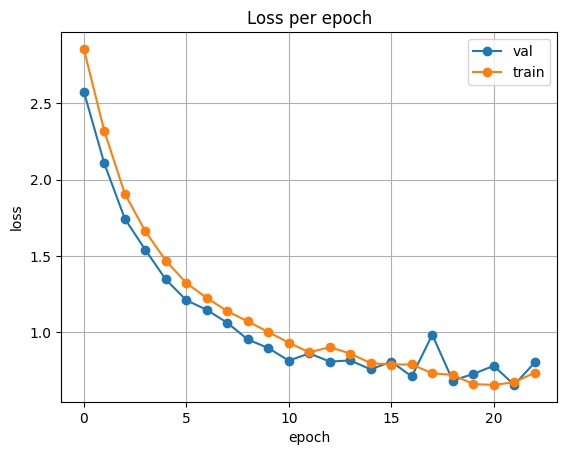

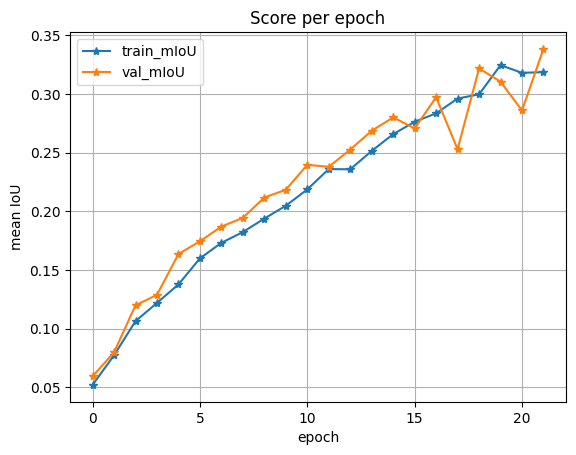

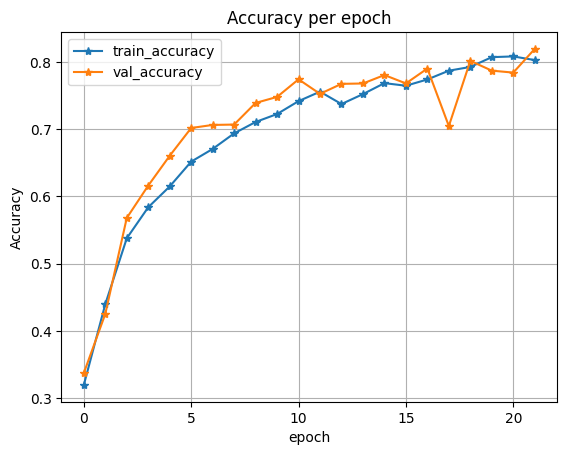

In [19]:
plot_loss(history)
plot_score(history)
plot_acc(history)

In [20]:
## Evaluation

In [21]:
class DroneTestDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask


t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

In [22]:
## Result

In [23]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [24]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [25]:
image, mask = test_set[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)

In [26]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [27]:
mob_miou = miou_score(model, test_set)

  0%|          | 0/40 [00:00<?, ?it/s]

In [28]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [29]:
mob_acc = pixel_acc(model, test_set)

  0%|          | 0/40 [00:00<?, ?it/s]

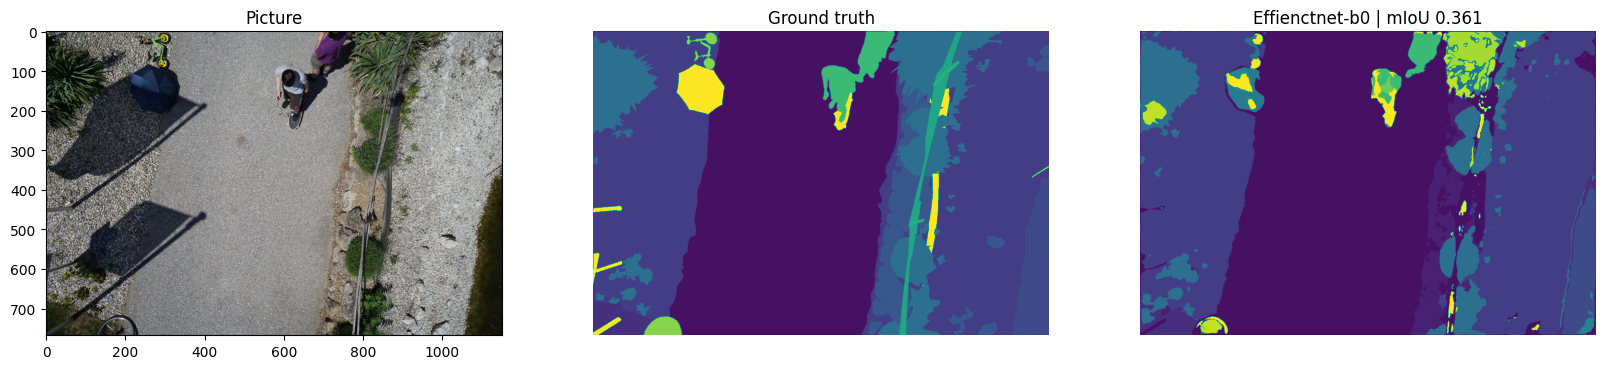

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('Effienctnet-b0 | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

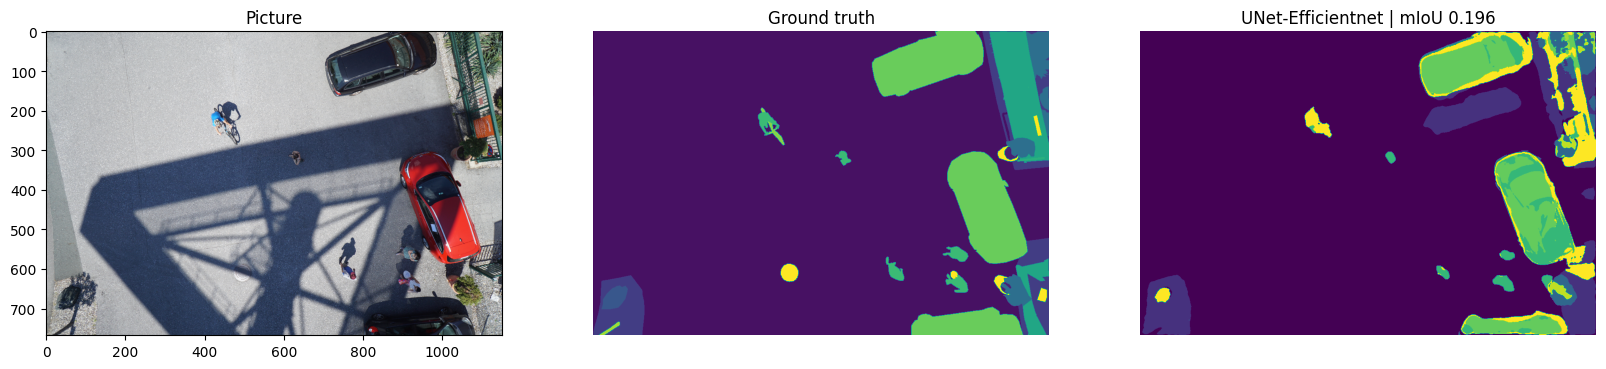

In [35]:
image2, mask2 = test_set[4]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2)
ax1.set_title('Picture');

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('UNet-Efficientnet | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()

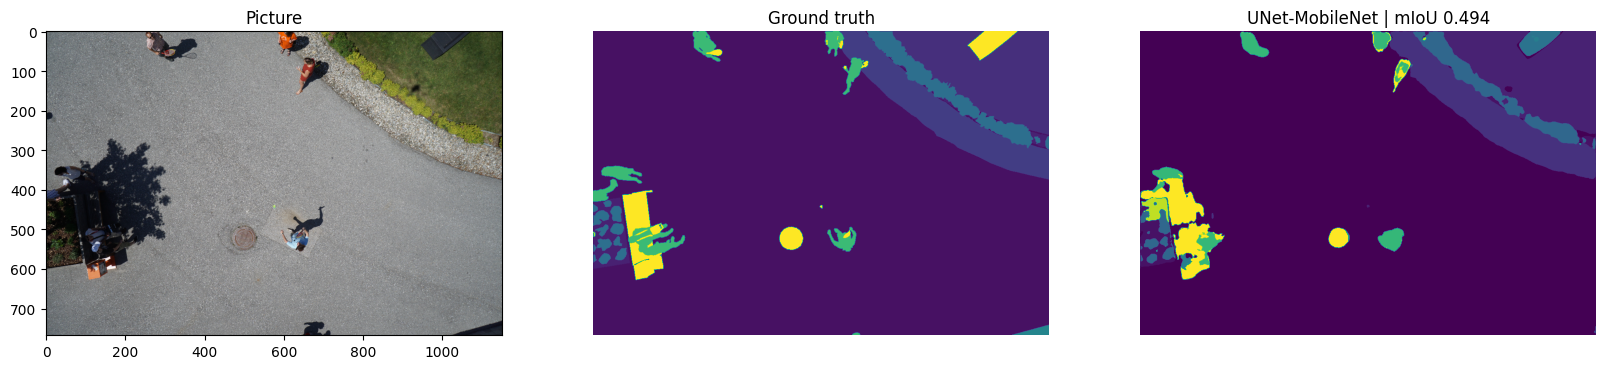

In [36]:
image3, mask3 = test_set[6]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image3)
ax1.set_title('Picture');

ax2.imshow(mask3)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score3))
ax3.set_axis_off()

In [37]:
print('Test Set mIoU', np.mean(mob_miou))

Test Set mIoU 0.31596177962236766


In [38]:
print('Test Set Pixel Accuracy', np.mean(mob_acc))

Test Set Pixel Accuracy 0.8275553950557002
